# Encoding URLs

In [6]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ROOT_DIR = os.path.dirname(os.path.abspath(""))

file = os.path.join(ROOT_DIR, "data/sitges_access.csv")
df = pd.read_csv(file)
df.head()

,Unnamed: 0,server_name,IP,logname,authenticate,date,petition,URL,status,bytes,referer,user-agent,level
0,0,sitgesanytime.com,47.76.35.19,-,-,2024-01-22 00:00:00+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,4840,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0
1,1,www.sitgesanytime.com,47.76.35.19,-,-,2024-01-22 00:00:01+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,200,5223,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0
2,2,www.sitgesanytime.com,40.77.167.53,-,-,2024-01-22 00:00:06+01:00,GET,/ca/noticias/84/sitges-obt%C3%A9-el-certificat...,404,2509,-,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",5
3,3,sitgesanytime.com,47.76.35.19,-,-,2024-01-22 00:00:06+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,4840,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0
4,4,www.sitgesanytime.com,47.76.35.19,-,-,2024-01-22 00:00:07+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,200,5260,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0


In [7]:
counts = pd.Series([str(u).split(" ")[-1] for u in df["URL"].unique()]).value_counts()
{url: count for url, count in counts.items() if count > 1}

{'HTTP/1.1': 69449, 'HTTP/2.0': 25303, 'HTTP/1.0': 158}

In [8]:
len(df[~df["URL"].str.contains("HTTP").astype(bool)])

432

In [9]:
clean_url = df[df["URL"].str.contains("HTTP").astype(bool)]["URL"].dropna()
counts = pd.Series([str(u).split(" ")[-1] for u in clean_url]).value_counts()
{url: f"{count/len(df):.2f}%" for url, count in counts.items()}

{'HTTP/2.0': '0.82%', 'HTTP/1.1': '0.18%', 'HTTP/1.0': '0.00%'}

## Tokenization

In [10]:
corpus = clean_url.to_list()
vocab_init = set(" ".join(corpus))
print(vocab_init)
corpus[:5]

{' ', 'H', ']', "'", 'r', 'c', 'L', 'h', 't', 'n', 'm', 'w', '$', '@', 'p', 'A', 'I', '?', '\\', 'F', '-', '7', 'E', 'z', 'a', 'v', 'W', 'X', ':', 'j', '=', '[', 'N', '2', '8', 'J', ')', 'q', 'Z', '!', 'l', 'd', '%', '5', 'b', 'O', '(', '*', 'Y', 'R', '3', 'S', 's', '1', '&', 'P', '>', 'G', '/', 'g', '}', 'K', 'y', '4', 'x', '{', 'Q', 'C', '+', '0', 'M', 'V', '.', 'U', 'k', '9', '_', ',', 'o', 'B', ';', 'i', 'D', 'u', 'e', '6', 'T', 'f'}


['/fr/pag492/explora-platges-i-ports-2/id12/les-anquines.htm HTTP/1.1',
 '/fr/pag492/explora-platges-i-ports-2/id12/les-anquines.htm HTTP/1.1',
 '/ca/noticias/84/sitges-obt%C3%A9-el-certificat-de-turisme-responsable-biosphere.html HTTP/2.0',
 '/fr/pag492/explora-platges-i-ports-2/id12/les-anquines.htm HTTP/1.1',
 '/fr/pag492/explora-platges-i-ports-2/id12/les-anquines.htm HTTP/1.1']

### Byte Pair Encoding (BPE)

In [34]:
from tokenizers import pre_tokenizers
alphabet = " ".join(pre_tokenizers.ByteLevel.alphabet())
alphabet[alphabet.find("ç")]

'ç'

In [6]:
from tokenizers import ByteLevelBPETokenizer # https://github.com/huggingface/tokenizers/blob/main/bindings/python/py_src/tokenizers/implementations/byte_level_bpe.py
tokenizer = ByteLevelBPETokenizer()

special_tokens = ["<s>", "<pad>", "</s>", "<unk>", "<mask>"]
tokenizer.train_from_iterator(corpus, vocab_size=1000, min_frequency=2, 
							  special_tokens=special_tokens)

In [7]:
tokenizer.save_model(os.path.join(ROOT_DIR, "models/"), prefix="bpe")

['/media/eric/D/repos/Synthesis-Project-1/models/bpe-vocab.json',
 '/media/eric/D/repos/Synthesis-Project-1/models/bpe-merges.txt']

In [66]:
tokenizer = ByteLevelBPETokenizer(
	vocab = os.path.join(ROOT_DIR, "models/", "bpe-vocab.json"),
	merges = os.path.join(ROOT_DIR, "models/", "bpe-merges.txt")
)

In [67]:
# print 5 longest vocab items
sorted(tokenizer.get_vocab(), key=len, reverse=True)[:5]

['oncssanimationend',
 'pictogramestaules',
 'responsivemenu',
 'cookiemanager',
 'internacional']

In [68]:
clean_url.iloc[0], clean_url.iloc[-1]

('/fr/pag492/explora-platges-i-ports-2/id12/les-anquines.htm HTTP/1.1',
 '/plantilles/turisme/css/estils-capcalera.css?v=3 HTTP/2.0')

In [69]:
print(tokenizer.encode(clean_url.iloc[0]).tokens)
print(tokenizer.encode(clean_url.iloc[-1]).tokens)

['/', 'fr', '/', 'pag', '492', '/', 'explora', '-', 'platges', '-', 'i', '-', 'ports', '-', '2', '/', 'id', '12', '/', 'les', '-', 'an', 'qu', 'in', 'es', '.', 'htm', 'ĠHTTP', '/', '1', '.', '1']
['/', 'plantilles', '/', 'turisme', '/', 'css', '/', 'estils', '-', 'capcalera', '.', 'css', '?', 'v', '=', '3', 'ĠHTTP', '/', '2', '.', '0']


In [71]:
tokenizer.encode("caça", add_special_tokens=True).tokens

['ca', 'Ã', '§', 'a']

### Wordpiece

In [100]:
from tokenizers import BertWordPieceTokenizer
tokenizer = BertWordPieceTokenizer()

special_tokens = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
tokenizer.train_from_iterator(corpus, vocab_size=1000, min_frequency=2, special_tokens=special_tokens)

In [101]:
tokenizer.save_model(os.path.join(ROOT_DIR, "models/"), prefix="wordpiece")

['/media/eric/D/repos/Synthesis-Project-1/models/wordpiece-vocab.txt']

In [102]:
tokenizer = BertWordPieceTokenizer(
	vocab = os.path.join(ROOT_DIR, "models/", "wordpiece-vocab.txt"),
)

In [103]:
# print 5 longest vocab items
sorted(tokenizer.get_vocab(), key=len, reverse=True)[:5]

['oncssanimationend',
 'pictogramestaules',
 'oncssanimation',
 'responsivemenu',
 '##ssanimation']

In [104]:
print(tokenizer.encode(clean_url.iloc[0]).tokens)
print(tokenizer.encode(clean_url.iloc[-1]).tokens)

['[CLS]', '/', 'fr', '/', 'pag', '##49', '##2', '/', 'explora', '-', 'platges', '-', 'i', '-', 'ports', '-', '2', '/', 'id1', '##2', '/', 'les', '-', 'an', '##qu', '##ine', '##s', '.', 'htm', 'http', '/', '1', '.', '1', '[SEP]']
['[CLS]', '/', 'plantilles', '/', 'turisme', '/', 'css', '/', 'estils', '-', 'capcalera', '.', 'css', '?', 'v', '=', '3', 'http', '/', '2', '.', '0', '[SEP]']


### Character-level BPE

In [113]:
initial_alphabet = list(set("".join(corpus)))
len(initial_alphabet)

88

In [114]:
from tokenizers import CharBPETokenizer
tokenizer = CharBPETokenizer(suffix="</w>", bert_normalizer=True)
tokenizer.train_from_iterator(corpus, vocab_size=1000, min_frequency=10, special_tokens=["<unk>"], initial_alphabet=initial_alphabet)
tokenizer.save_model(os.path.join(ROOT_DIR, "models/"), prefix="charbpe")
tokenizer = CharBPETokenizer(
	vocab=os.path.join(ROOT_DIR, "models/", "charbpe-vocab.json"),
	merges=os.path.join(ROOT_DIR, "models/", "charbpe-merges.txt")
)

In [115]:
set(initial_alphabet) < set(tokenizer.get_vocab().keys())

True

In [116]:
clean_url.iloc[0]

'/fr/pag492/explora-platges-i-ports-2/id12/les-anquines.htm HTTP/1.1'

In [117]:
print(tokenizer.encode(clean_url.iloc[0], add_special_tokens=True).tokens)

['/</w>', 'fr</w>', '/</w>', 'pag', '4', '92</w>', '/</w>', 'explora</w>', '-</w>', 'platges</w>', '-</w>', 'i</w>', '-</w>', 'ports</w>', '-</w>', '2</w>', '/</w>', 'id1', '2</w>', '/</w>', 'les</w>', '-</w>', 'an', 'qu', 'in', 'es</w>', '.</w>', 'htm</w>', 'HTTP</w>', '/</w>', '1</w>', '.</w>', '1</w>']


In [118]:
from tqdm import tqdm
from collections import Counter

tokenizer = CharBPETokenizer(
	vocab=os.path.join(ROOT_DIR, "models/", "charbpe-vocab.json"),
	merges=os.path.join(ROOT_DIR, "models/", "charbpe-merges.txt")
)

tokenized_corpus = []
for url in tqdm(corpus):
	tokenized_corpus.append(tokenizer.encode(url).tokens)

In [95]:
def preprocess(tokenized_corpus, min_frequency=5):
	token_counts = Counter([token for url in tokenized_corpus for token in url])
	trimmed = []
	for url in tqdm(tokenized_corpus):
		trimmed_url = []
		for token in url:
			if token_counts[token] >= min_frequency:
				trimmed_url.append(token)
			else:
				trimmed_url.append("<unk>")
		trimmed.append(trimmed_url)
	return trimmed

trimmed_tokenized_corpus = preprocess(tokenized_corpus)

100%|██████████| 1076959/1076959 [00:05<00:00, 187572.18it/s]


In [96]:
tokens = [token for url in trimmed_tokenized_corpus for token in url]
len(trimmed_tokenized_corpus), len(tokens), len(set(tokens))

(1076959, 25457221, 923)

In [119]:
vocab_t = set(tokenizer.get_vocab().keys())
vocab_c = set(tokens)
len(vocab_t), len(vocab_c)

(1000, 923)

In [120]:
missing = vocab_t - vocab_c
not_missing = vocab_t & vocab_c

In [121]:
to_remove = []
for t1 in missing:
	found = False
	for t2 in not_missing:
		if t1 in t2:
			# print(t1, t2)
			found = True
	if not found:
		to_remove.append(t1)
to_remove

[' ',
 ']',
 '{</w>',
 '[',
 '}</w>',
 '*',
 '*</w>',
 '}',
 '></w>',
 '{',
 ']</w>',
 '[</w>']

In [124]:
" " in tokenizer.get_vocab(), tokenizer.encode("hello world").tokens

(True, ['hel', 'l', 'o</w>', 'wor', 'l', 'd</w>'])

In [125]:
"<unk>" in "".join([t for u in trimmed_tokenized_corpus for t in u]), "]" in "".join([t for u in tokenized_corpus for t in u])

(True, True)

In [126]:
tokenizer.encode("hello]").tokens

['hel', 'l', 'o</w>', ']</w>']

In [105]:
import json
with open(os.path.join(ROOT_DIR, "models/", "charbpe-vocab.json"), "r") as f:
	vocab = json.load(f)
vocab_tokens = list(vocab.keys())
vocab_tokens[:5]

['<unk>', ' ', '!', '$', '%']

In [136]:
new_vocab = [t for t in vocab_tokens if t not in to_remove]
len(new_vocab), len(vocab_tokens)

(988, 1000)

In [138]:
new_vocab = {t:i for i,t in enumerate(new_vocab)}
list(zip(new_vocab.items()))[:5]

[(('<unk>', 0),), (('!', 1),), (('$', 2),), (('%', 3),), (('&', 4),)]

In [139]:
with open(os.path.join(ROOT_DIR, "models/", "charbpe-vocab.json"), "w") as f:
	json.dump(new_vocab, f)

In [140]:
tokenizer = CharBPETokenizer(
	vocab=os.path.join(ROOT_DIR, "models/", "charbpe-vocab.json"),
	merges=os.path.join(ROOT_DIR, "models/", "charbpe-merges.txt")
)
len(tokenizer.get_vocab())

988

## Embeddings

### Word2Vec SkipGram (vanilla)

In [11]:
from tokenizers import CharBPETokenizer
tokenizer = CharBPETokenizer(
	vocab=os.path.join(ROOT_DIR, "models/", "charbpe-vocab.json"),
	merges=os.path.join(ROOT_DIR, "models/", "charbpe-merges.txt")
)

In [8]:
from tqdm import tqdm
tokenized_corpus = []
for url in tqdm(corpus):
	tokenized_corpus.append(tokenizer.encode(url).tokens)
tokenized_corpus[:3]

100%|██████████| 1076959/1076959 [00:39<00:00, 27195.69it/s]


[['/</w>',
  'fr</w>',
  '/</w>',
  'pag',
  '4',
  '92</w>',
  '/</w>',
  'explora</w>',
  '-</w>',
  'platges</w>',
  '-</w>',
  'i</w>',
  '-</w>',
  'ports</w>',
  '-</w>',
  '2</w>',
  '/</w>',
  'id1',
  '2</w>',
  '/</w>',
  'les</w>',
  '-</w>',
  'an',
  'qu',
  'in',
  'es</w>',
  '.</w>',
  'htm</w>',
  'HTTP</w>',
  '/</w>',
  '1</w>',
  '.</w>',
  '1</w>'],
 ['/</w>',
  'fr</w>',
  '/</w>',
  'pag',
  '4',
  '92</w>',
  '/</w>',
  'explora</w>',
  '-</w>',
  'platges</w>',
  '-</w>',
  'i</w>',
  '-</w>',
  'ports</w>',
  '-</w>',
  '2</w>',
  '/</w>',
  'id1',
  '2</w>',
  '/</w>',
  'les</w>',
  '-</w>',
  'an',
  'qu',
  'in',
  'es</w>',
  '.</w>',
  'htm</w>',
  'HTTP</w>',
  '/</w>',
  '1</w>',
  '.</w>',
  '1</w>'],
 ['/</w>',
  'ca</w>',
  '/</w>',
  'noticias</w>',
  '/</w>',
  '8',
  '4</w>',
  '/</w>',
  'sitges</w>',
  '-</w>',
  'ob',
  't</w>',
  '%</w>',
  'C3</w>',
  '%</w>',
  'A',
  '9</w>',
  '-</w>',
  'el</w>',
  '-</w>',
  'cer',
  'ti',
  'fi',
  'ca

In [9]:
word2idx = tokenizer.get_vocab()
idx2word = {idx: word for word, idx in word2idx.items()}

In [10]:
def get_training_data(tokenized_corpus, word2idx, window_size=2):
	training_data = []
	for sentence in tqdm(tokenized_corpus):
		sentence_indices = [word2idx[word] for word in sentence]
		for center_word_pos in range(len(sentence_indices)):
			for w in range(-window_size, window_size + 1):
				context_word_pos = center_word_pos + w
				if context_word_pos < 0 or context_word_pos >= len(sentence_indices) or center_word_pos == context_word_pos:
					continue
				center_word_idx = sentence_indices[center_word_pos]
				context_word_idx = sentence_indices[context_word_pos]
				training_data.append((center_word_idx, context_word_idx))
	return training_data

training_data = get_training_data(tokenized_corpus, word2idx)
training_data[0]

100%|██████████| 1076959/1076959 [00:21<00:00, 50735.66it/s]


(165, 363)

In [12]:
[(idx2word[center], idx2word[context]) for center, context in training_data[:10]]

[('/</w>', 'fr</w>'),
 ('/</w>', '/</w>'),
 ('fr</w>', '/</w>'),
 ('fr</w>', '/</w>'),
 ('fr</w>', 'pag'),
 ('/</w>', '/</w>'),
 ('/</w>', 'fr</w>'),
 ('/</w>', 'pag'),
 ('/</w>', '4'),
 ('pag', 'fr</w>')]

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class Word2VecSkipGram(nn.Module):
	def __init__(self, vocab_size, embedding_dim):
		super(Word2VecSkipGram, self).__init__()
		self.embeddings = nn.Embedding(vocab_size, embedding_dim)
		self.linear = nn.Linear(embedding_dim, vocab_size)
		
	def forward(self, x):
		x = self.embeddings(x)
		x = self.linear(F.relu(x))
		return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Word2VecSkipGram(vocab_size=len(word2idx), embedding_dim=100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model

Word2VecSkipGram(
  (embeddings): Embedding(1000, 100)
  (linear): Linear(in_features=100, out_features=1000, bias=True)
)

In [31]:
class Word2VecDataset(Dataset):
	def __init__(self, training_data):
		self.training_data = training_data
		
	def __len__(self):
		return len(self.training_data)
	
	def __getitem__(self, idx):
		center_word_idx, context_word_idx = self.training_data[idx]
		return center_word_idx, context_word_idx
	
train_size = int(0.6 * len(training_data))
val_size = int(0.2 * len(training_data))
test_size = len(training_data) - train_size - val_size
train_data = training_data[:train_size]
val_data = training_data[train_size:train_size + val_size]
test_data = training_data[-test_size:]

train_dataset = Word2VecDataset(train_data)
val_dataset = Word2VecDataset(val_data)
test_dataset = Word2VecDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [32]:
def train(model, criterion, optimizer, train_loader, val_loader, device, n_epochs=10):
	training_losses = []
	val_losses = []
	for epoch in range(n_epochs):
		model.train()
		train_loss = 0
		for i, (center_word_idxs, context_word_idxs) in enumerate(train_loader):
			center_word_idxs = center_word_idxs.to(device)
			context_word_idxs = context_word_idxs.to(device)
			optimizer.zero_grad()
			outputs = model(center_word_idxs)
			loss = criterion(outputs, context_word_idxs)
			loss.backward()
			optimizer.step()
			train_loss += loss.item()
			print(f"Epoch {epoch + 1}/{n_epochs} Batch {i + 1}/{len(train_loader)} Loss: {loss.item():.4f}", end="\r")
		training_losses.append(train_loss / len(train_loader))
		model.eval()
		val_loss = 0
		with torch.no_grad():
			for center_word_idxs, context_word_idxs in val_loader:
				center_word_idxs = center_word_idxs.to(device)
				context_word_idxs = context_word_idxs.to(device)
				outputs = model(center_word_idxs)
				loss = criterion(outputs, context_word_idxs)
				val_loss += loss.item()
		val_losses.append(val_loss / len(val_loader))
		print(f"Epoch {epoch + 1}/{n_epochs} Training Loss: {training_losses[-1]:.4f} Validation Loss: {val_losses[-1]:.4f}", end="\r")
	return training_losses, val_losses

def test(model, criterion, test_loader, device):
	model.eval()
	test_loss = 0
	with torch.no_grad():
		for center_word_idxs, context_word_idxs in test_loader:
			center_word_idxs = center_word_idxs.to(device)
			context_word_idxs = context_word_idxs.to(device)
			outputs = model(center_word_idxs)
			loss = criterion(outputs, context_word_idxs)
			test_loss += loss.item()
	return test_loss / len(test_loader)

def plot_losses(training_losses, val_losses):
	plt.plot(training_losses, label="Training Loss")
	plt.plot(val_losses, label="Validation Loss")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.show()

In [33]:
train_losses, val_losses = train(model, criterion, optimizer, train_loader, val_loader, device, n_epochs=1)

In [34]:
test(model, criterion, test_loader, device)

3.014350344884184

In [39]:
embeddings = model.embeddings.weight.data.cpu().numpy()
embeddings.shape

(1000, 100)

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)
reduced_embeddings.shape

(1000, 2)

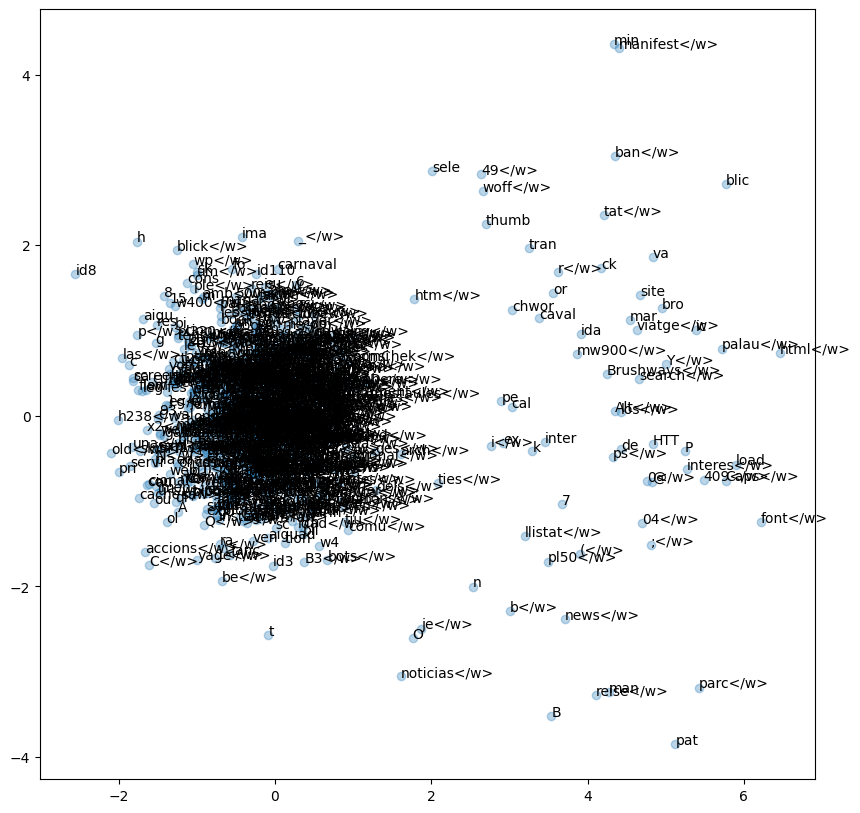

In [41]:
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.3)
for i, word in enumerate(word2idx.keys()):
	plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.show()

In [54]:
# test model with a token
token = "HTTP</w>"
token_idx = word2idx[token]
with torch.no_grad():
	out_vector = model(torch.tensor([token_idx]).to(device), None)
	out_probs = F.softmax(out_vector, dim=1).cpu().numpy()

# top 5
top5_idx = out_probs.argsort()[0][::-1][:5]
top5_tokens = [idx2word[idx] for idx in top5_idx]
top5_tokens

['/</w>', '2</w>', '.</w>', '=</w>', '1</w>']

### Word2Vec SkipGram (implemented as in Mikolov et al.)
- Subsampling
- Negative sampling

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from tokenizers import CharBPETokenizer
from collections import Counter
import numpy as np
import random
import gc, os